In [ ]:
# Install ucimlrepo
!pip install ucimlrepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import autocorrelation_plot

In [ ]:


# -------------------------------
# 1. Load Dataset
# -------------------------------
data = fetch_ucirepo(id=235)
X = data.data.features
y = data.data.targets

df = pd.concat([X, y], axis=1)

print("Shape of dataset:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

# -------------------------------
# 1b. Data Cleaning & Conversion
# -------------------------------
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

# Convert to numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Combine Date + Time
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df = df.drop(columns=['Date', 'Time'])
df = df.set_index('datetime')

# Fill missing values (forward/backward fill for time series)
df = df.fillna(method='ffill').fillna(method='bfill')

print("\nAfter cleaning:")
print(df.info())

# -------------------------------
# 1c. CREATE HOURLY RESAMPLED DATA
# -------------------------------
df_hourly = df.resample('h').mean()  # Resample to hourly
print(f"\nHourly data shape: {df_hourly.shape}")
print("Hourly data info:")
print(df_hourly.info())













/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Shape of dataset: (2075259, 9)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None

Missing values per column:
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


/tmp/ipython-input-4036323098.py:29: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
/tmp/ipython-input-4036323098.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')



After cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None

Hourly data shape: (34589, 7)
Hourly data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: h
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Gl

In [ ]:
# -------------------------------
# 2. Summary Stats
# -------------------------------
print("\nSummary Statistics (Original Data):")
print(df.describe().T)

print("\nSummary Statistics (Hourly Data):")
print(df_hourly.describe().T)


Summary Statistics (Original Data):
                           count        mean       std      min      25%  \
Global_active_power    2075259.0    1.086168  1.053172    0.076    0.308   
Global_reactive_power  2075259.0    0.123328  0.112514    0.000    0.048   
Voltage                2075259.0  240.841608  3.235574  223.200  239.000   
Global_intensity       2075259.0    4.604226  4.426775    0.200    1.400   
Sub_metering_1         2075259.0    1.110995  6.115908    0.000    0.000   
Sub_metering_2         2075259.0    1.287958  5.786865    0.000    0.000   
Sub_metering_3         2075259.0    6.416570  8.419505    0.000    0.000   

                           50%      75%      max  
Global_active_power      0.598    1.524   11.122  
Global_reactive_power    0.100    0.194    1.390  
Voltage                241.020  242.870  254.150  
Global_intensity         2.600    6.400   48.400  
Sub_metering_1           0.000    0.000   88.000  
Sub_metering_2           0.000    1.000   80.000

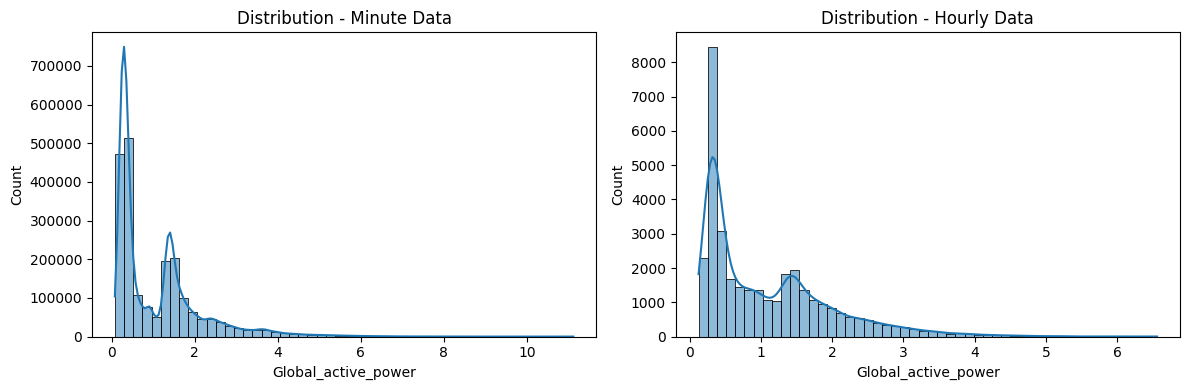

In [ ]:
# -------------------------------
# 3. Target Distribution
# -------------------------------
target_col = 'Global_active_power'

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df[target_col].dropna(), bins=50, kde=True)
plt.title("Distribution - Minute Data")

plt.subplot(1,2,2)
sns.histplot(df_hourly[target_col].dropna(), bins=50, kde=True)
plt.title("Distribution - Hourly Data")

plt.tight_layout()
plt.show()

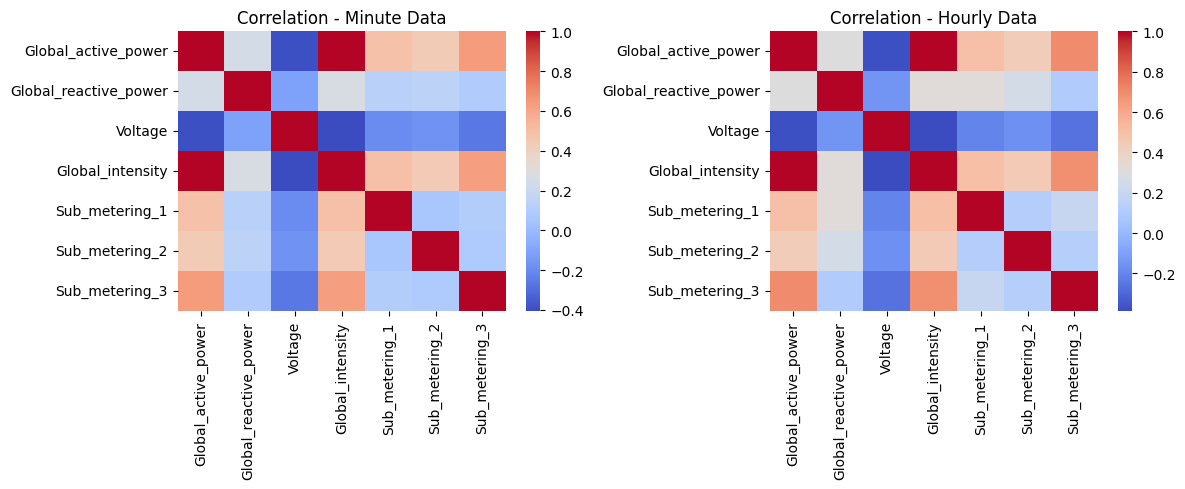

In [ ]:
# -------------------------------
# 4. Correlation Heatmap
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
corr_minute = df.corr()
sns.heatmap(corr_minute, cmap="coolwarm", annot=False)
plt.title("Correlation - Minute Data")

plt.subplot(1,2,2)
corr_hourly = df_hourly.corr()
sns.heatmap(corr_hourly, cmap="coolwarm", annot=False)
plt.title("Correlation - Hourly Data")

plt.tight_layout()
plt.show()

Feature importance data shape: (34589, 6)

Top 10 Features by Importance:
                 feature  importance
2       Global_intensity    0.999397
1                Voltage    0.000255
0  Global_reactive_power    0.000210
5         Sub_metering_3    0.000076
3         Sub_metering_1    0.000043
4         Sub_metering_2    0.000018


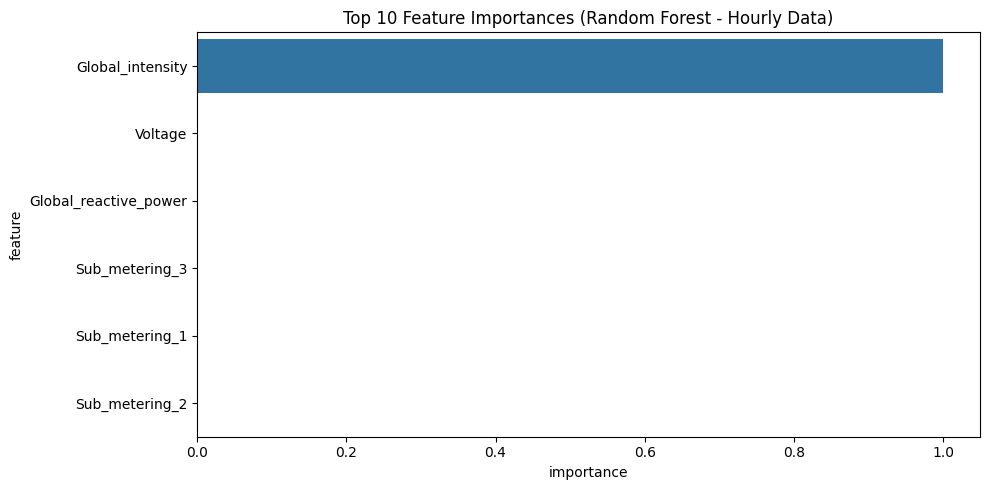

In [ ]:
# -------------------------------
# 5. Feature Importance (Random Forest) - USE HOURLY DATA
# -------------------------------
# Now df_hourly exists!
df_clean = df_hourly.dropna()
X_clean = df_clean.drop(columns=[target_col])
y_clean = df_clean[target_col]

print(f"Feature importance data shape: {X_clean.shape}")

# Use smaller/faster RF for quick importance
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=10)
rf.fit(X_clean, y_clean)

importances = pd.DataFrame({
    "feature": X_clean.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 10 Features by Importance:")
print(importances.head(10))

plt.figure(figsize=(10,5))
sns.barplot(x="importance", y="feature", data=importances.head(10))
plt.title("Top 10 Feature Importances (Random Forest - Hourly Data)")
plt.tight_layout()
plt.show()

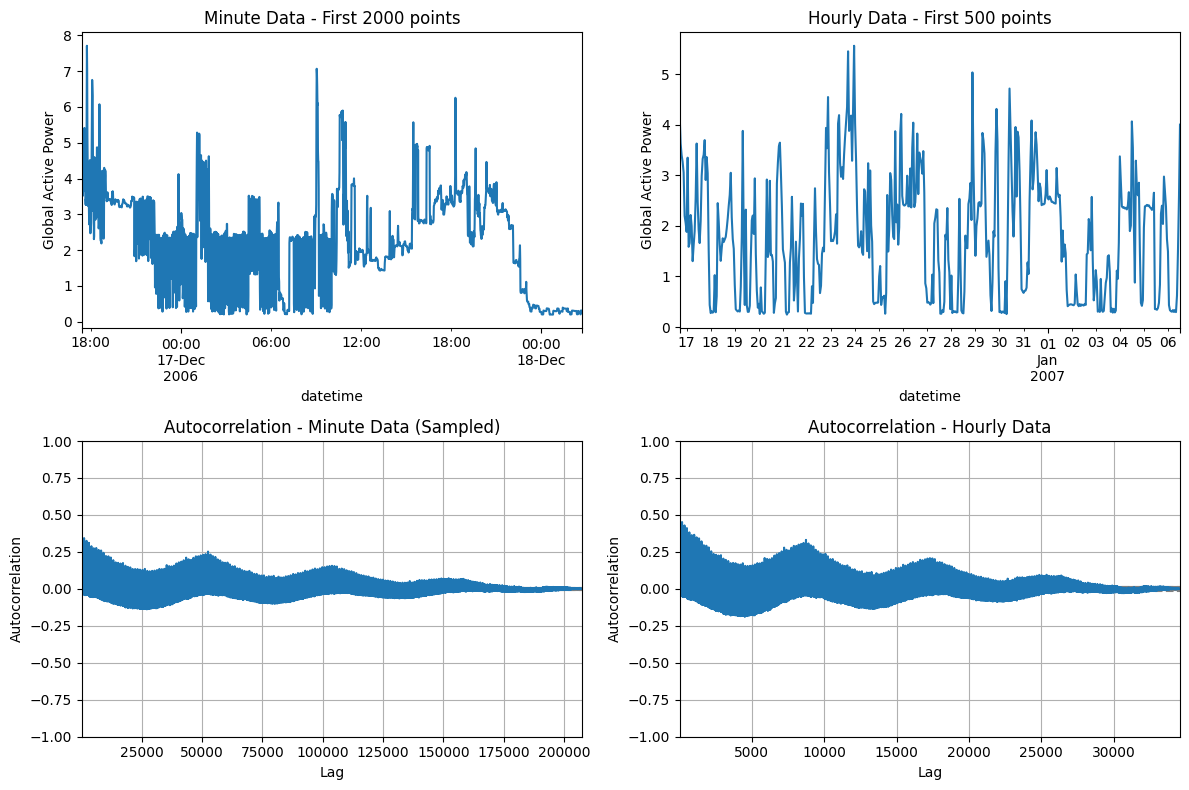

In [ ]:
# -------------------------------
# 6. Time Series Analysis - OPTIMIZED
# -------------------------------
plt.figure(figsize=(12,8))

# Minute data sample
plt.subplot(2,2,1)
df[target_col].iloc[:2000].plot()
plt.title("Minute Data - First 2000 points")
plt.ylabel("Global Active Power")

# Hourly data sample
plt.subplot(2,2,2)
df_hourly[target_col].iloc[:500].plot()
plt.title("Hourly Data - First 500 points")
plt.ylabel("Global Active Power")

# FASTER Autocorrelation - minute (use downsampled data)
plt.subplot(2,2,3)
minute_sample = df[target_col].iloc[::10]  # Sample every 10th point
autocorrelation_plot(minute_sample)
plt.title("Autocorrelation - Minute Data (Sampled)")

# Autocorrelation - hourly (this should be fast enough)
plt.subplot(2,2,4)
autocorrelation_plot(df_hourly[target_col])
plt.title("Autocorrelation - Hourly Data")

plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------
# 7. Additional Analysis - Compare Data Granularity
# -------------------------------
print(f"\nData Granularity Comparison:")
print(f"Original data: {df.shape[0]:,} rows (minute-level)")
print(f"Hourly data:   {df_hourly.shape[0]:,} rows")
print(f"Reduction:     {df.shape[0]/df_hourly.shape[0]:.1f}x smaller")

# Check data spans
print(f"\nDate ranges:")
print(f"Original: {df.index.min()} to {df.index.max()}")
print(f"Hourly:   {df_hourly.index.min()} to {df_hourly.index.max()}")


Data Granularity Comparison:
Original data: 2,075,259 rows (minute-level)
Hourly data:   34,589 rows
Reduction:     60.0x smaller

Date ranges:
Original: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Hourly:   2006-12-16 17:00:00 to 2010-11-26 21:00:00
